# Huggingface intro to Transformer based models

In [7]:
from transformers import pipeline
import torch

In [ ]:
# Ok so basically pipelines include pre-processing, inference and postprocessing. From beginning to end, they allow you to run a model with 
# just a few lines of code.

sentiments = pipeline("sentiment-analysis")

sentiments("I am not too sure about this course")

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

c:\Users\mirko\Documents\Coding\transformers\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mirko\.cache\huggingface\hub\models--distilbert--distilbert-base-uncased-finetuned-sst-2-english. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


[{'label': 'NEGATIVE', 'score': 0.9996360540390015}]

## Behind the Pipeline

You can break down the Pipeline in:
- Pre-processing --> Tokenizer (needs to be the same as the one used for training the model of course)
- Model Inference
- Post-processing

### Tokenizer
https://huggingface.co/learn/llm-course/chapter2/6?fw=pt

In [2]:
# Pre-processing with tokenizers -> we can use AutoTokenizer to load the tokenizer for a specific model, using 'from_pretrained' method.

from transformers import AutoTokenizer
checkpoint = "distilbert-base-uncased-finetuned-sst-2-english"

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")


In [ ]:
# If we we try passing some text to the tokenizer we get 
# 1) the 'input_ids' (integers) in the output you request (tensors in this case) 
# 2) the 'attention_mask'

raw_text = ['Testing that the chosen tokenizer works.', 
            "Here's another sentence"]

inputs = tokenizer(raw_text, padding=True, truncation=True, return_tensors='pt')

# ALTERNATIVELY, spelled out, we can also first tokenize and then convert into dictionary IDs
tokens = tokenizer.tokenize(raw_text)
ids = tokenizer.convert_tokens_to_ids(tokens)
input_ids = torch.tensor(ids)


In [6]:
tokens

['testing',
 'that',
 'the',
 'chosen',
 'token',
 '##izer',
 'works',
 '.',
 'here',
 "'",
 's',
 'another',
 'sentence']

#### What about *Padding*?

When batch size >1, we feed multiple sentences to the model. The model, however, only accepts inputs of rectangular shape (tensors) therefore we need *padding* to make all the sequences the same length.

Basically, a *padding token* is added. We also need to tell the attention layers in the model to ignore the padding tokens - that's where the *attention mask* comes in.


In [8]:
inputs['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])

In [9]:
inputs

{'input_ids': tensor([[  101,  5604,  2008,  1996,  4217, 19204, 17629,  2573,  1012,   102],
        [  101,  2182,  1005,  1055,  2178,  6251,   102,     0,     0,     0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0]])}

#### Sequence length: how long can you go?
Most models handle sequences up to 512 or 1024 tokens. We can either truncate sequences or use a model with longer supported sequence length

### Loading the model

The vector outputted by the core transformer module is an embedding representing the input, of size:
- batch_size (Number of sequences (sentences) processed each time - 2 in this case)
- Sequence length (the number of tokens contained in each sequence)
- Hidden size (the vector dimensions of each input - from 768 from smaller models to 3k+ for larger ones)

In this diagram below, the model is represented by its embeddings layer and the subsequent layers. The embeddings layer converts each input ID in the tokenized input into a vector that represents the associated token. The subsequent layers manipulate those vectors using the attention mechanism to produce the final representation of the sentences.

What exactly gets loaded? 2 things: The config file containing the model architecture description and the .bin file, containing model weights

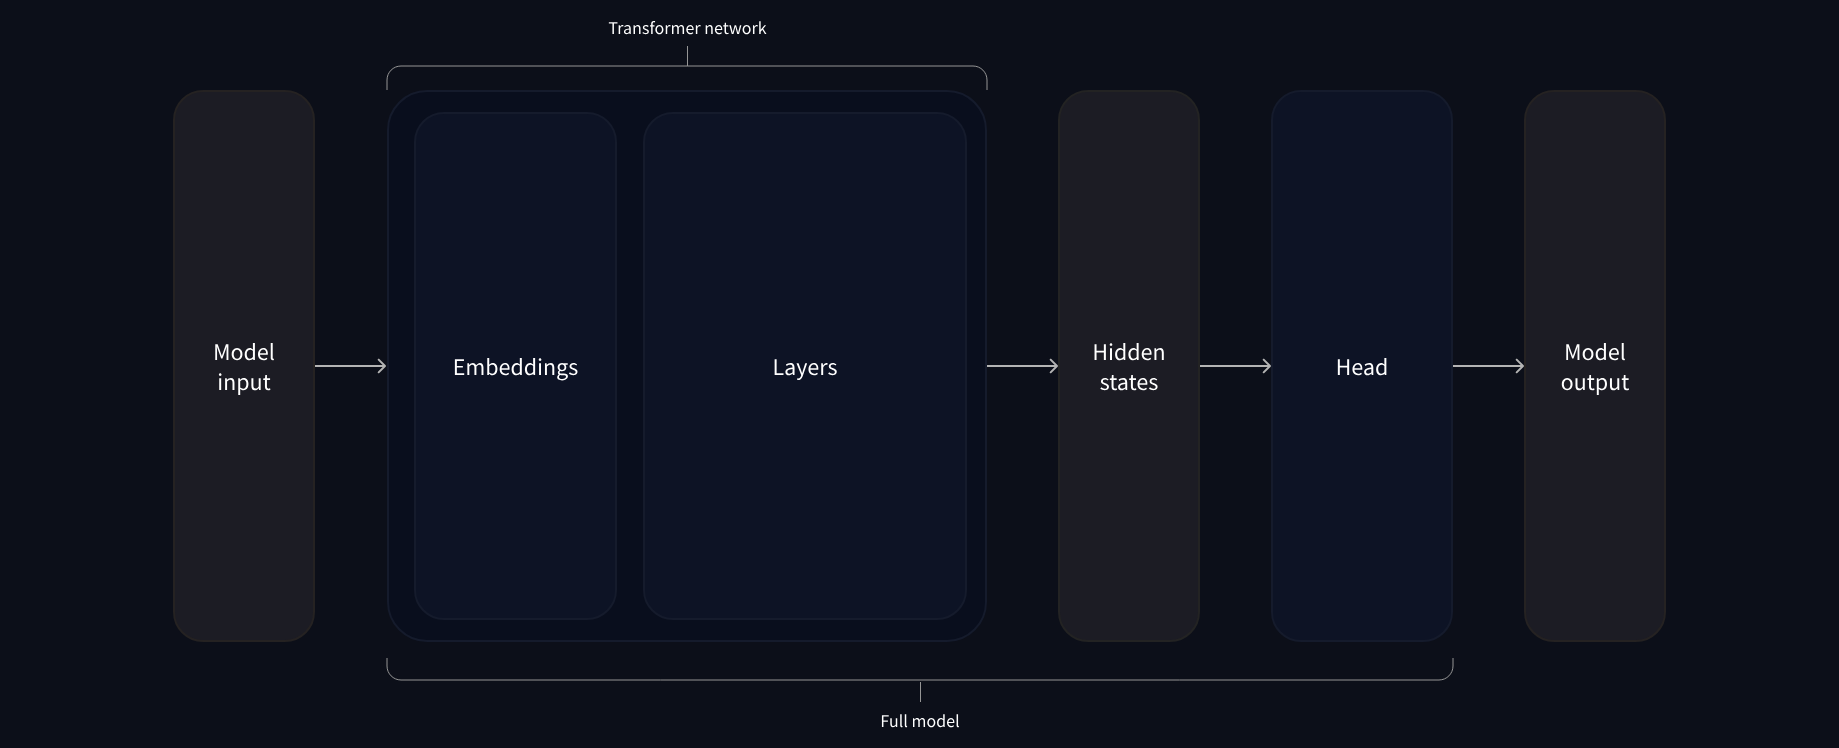

In [9]:
from transformers import AutoModel

model = AutoModel.from_pretrained(checkpoint)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [16]:
# This is just the base Transformer module - it outputs hidden states, also known as features (embeddings?)
outputs = model(**inputs)

In [24]:
outputs[0].shape

torch.Size([2, 10, 768])

### Now we need a Head to interpret the model hidden states

In [ ]:
# Not sure how to call the head directly on the outputs of the previous run. But we can call directly the combination of transformer base and head for a specific task.
# There can be multiple heads for the same base, specializing the model in a given task (is Head = to fineturning? --> NO! )

from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [ ]:
# The model needs tensors of tokens to produce logits. You can build them putting a list of list of tokens through a tensor 

inputs['input_ids']

tensor([[  101,  5604,  2008,  1996,  4217, 19204, 17629,  2573,  1012,   102],
        [  101,  2182,  1005,  1055,  2178,  6251,   102,     0,     0,     0]])

In [ ]:
# The output of this step is LOGITS - it is the final output of the transformer
outputs = model(**inputs)
outputs

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.5675, -0.3028],
        [ 2.9117, -2.5049]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
outputs.logits

tensor([[ 0.5675, -0.3028],
        [ 2.9117, -2.5049]], grad_fn=<AddmmBackward0>)

### Postprocessing - from Logits to an actual prediction
From the previous step we get Logits, the raw, unnormalized scores outputted by the last layer of the model. All Hugginface Transformers models output logits, as the loss function for training will generally fuse the last activation function, such as SoftMax, with the actual loss function, such as cross entropy.

To be converted to probabilities, Logits need to go through a SoftMax layer 


In [35]:
import torch 

predictions = torch.nn.functional.softmax(input=outputs.logits, dim=-1 )
predictions

tensor([[0.7048, 0.2952],
        [0.9956, 0.0044]], grad_fn=<SoftmaxBackward0>)

In [ ]:
# What do the predictions mean? we can check the model config for the labels in label2id
model.config

DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "finetuning_task": "sst-2",
  "hidden_dim": 3072,
  "id2label": {
    "0": "NEGATIVE",
    "1": "POSITIVE"
  },
  "initializer_range": 0.02,
  "label2id": {
    "NEGATIVE": 0,
    "POSITIVE": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.52.3",
  "vocab_size": 30522
}

## Fine-Tuning a pretrained model

Alright, we have seen how to do simple inference on a given model, starting from tokenizing input to calling the model and postprocessing. Now we talk about fine-tuning of a pretrained model

### Datasets and Pre-processing


In [ ]:
# Loading a dataset containing 2 sentences and a label (0/1) to indicate whether they are of same meaning or not.

from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

README.md:   0%|          | 0.00/35.3k [00:00<?, ?B/s]

c:\Users\mirko\Documents\Coding\transformers\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\mirko\.cache\huggingface\hub\datasets--glue. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


train-00000-of-00001.parquet:   0%|          | 0.00/649k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/308k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [ ]:
# you can call each x,y,label pair by idx
raw_datasets['test'][0]

{'sentence1': "PCCW 's chief operating officer , Mike Butcher , and Alex Arena , the chief financial officer , will report directly to Mr So .",
 'sentence2': 'Current Chief Operating Officer Mike Butcher and Group Chief Financial Officer Alex Arena will report to So .',
 'label': 1,
 'idx': 0}

In [ ]:
# you can also look at the metadata available about features in the datasets object
raw_datasets['train'].features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [21]:
raw_datasets['train'][0]['sentence1']

'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .'

In [ ]:
# then remember to tokenize it's 

from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenized_sentences_1 = tokenizer(raw_datasets['train'][15]['sentence1'])
tokenized_sentences_2 = tokenizer(raw_datasets['train'][15]['sentence2'])

In [35]:
tokenized_sentences_1

{'input_ids': [101, 24049, 2001, 2087, 3728, 3026, 3580, 2343, 2005, 1996, 9722, 1004, 4132, 9340, 12439, 2964, 2449, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [36]:
tokenized_sentences_2

{'input_ids': [101, 3026, 3580, 2343, 4388, 24049, 1010, 3839, 2132, 1997, 1996, 9722, 1998, 4132, 9340, 12439, 2964, 3131, 1010, 2097, 2599, 1996, 2047, 9178, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# tokenizer takes care of adding start - stop tokens and pre processing 
tokenizer.convert_ids_to_tokens(tokenized_sentences_1['input_ids'])

['[CLS]',
 'rudder',
 'was',
 'most',
 'recently',
 'senior',
 'vice',
 'president',
 'for',
 'the',
 'developer',
 '&',
 'platform',
 'evan',
 '##gel',
 '##ism',
 'business',
 '.',
 '[SEP]']

In [58]:
raw_datasets['train']['sentence1']

['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
 'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
 'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
 'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .',
 'Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .',
 'The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .',
 'The DVD-CCA then appealed to the state Supreme Court .',
 'That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .',
 'Shares of Genentech , a much larger company with several products on the market , rose more than 2 percent .

In [59]:
# and it can also take the whole dataset in the format required by the model

tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
)

# the problem is that this gets stored IN MEMORY, so it has to be <RAM
# To store the dataset on disk and access only samples of it at a time, you can use Dataset.map() method. Below is how

# first create a tokenize_funciton() function that defines what happens to each batch of dataset

def tokenize_funciton(example):
    return tokenizer(example['sentence1'], example['sentence2'], truncation=True)  #note we truncate at batch level, so max length might be different among batches --> therefore we need dynamic padding to bring all batches size to the size of the longest one

# then we apply .map

tokenized_dataset = raw_datasets.map(tokenize_funciton, batched = True)


Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [60]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [62]:
# we have to define a collate function that will apply the correct amount of padding to the items of the dataset we want to batch together. 
# we can do so with DataCollatorWithPadding, which once you give it a tokenizer it will help you create batches with equal padding

from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# gather some samples we want to batch together 
samples = tokenized_dataset["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
print([len(x) for x in samples["input_ids"]] )  # len of sequences. We want to batch them together


batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}



[50, 59, 47, 67, 59, 50, 62, 32]


{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}

In [63]:
batch

{'input_ids': tensor([[  101,  2572,  3217,  5831,  5496,  2010,  2567,  1010,  3183,  2002,
          2170,  1000,  1996,  7409,  1000,  1010,  1997,  9969,  4487, 23809,
          3436,  2010,  3350,  1012,   102,  7727,  2000,  2032,  2004,  2069,
          1000,  1996,  7409,  1000,  1010,  2572,  3217,  5831,  5496,  2010,
          2567,  1997,  9969,  4487, 23809,  3436,  2010,  3350,  1012,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [  101,  9805,  3540, 11514,  2050,  3079, 11282,  2243,  1005,  1055,
          2077,  4855,  1996,  4677,  2000,  3647,  4576,  1999,  2687,  2005,
          1002,  1016,  1012,  1019,  4551,  1012,   102,  9805,  3540, 11514,
          2050,  4149, 11282,  2243,  1005,  1055,  1999,  2786,  2005,  1002,
          6353,  2509,  2454,  1998,  2853,  2009,  2000,  3647,  4576,  2005,
          1002,  1015,  1012,  1022,  4551,  1999,  2687, 

### Fine-tuning training

In [3]:
# First we define the training arguments - even before picking the model? weird

from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

# then we pick the model 

from transformers import AutoModelForAudioClassification
model = AutoModelForAudioClassification.from_pretrained(checkpoint, num_labels=2)

NameError: name 'checkpoint' is not defined

In [2]:
training_args

TrainingArguments(
_n_gpu=0,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use_gather_object=False,
